In [2]:
import truth_request as tr
import truth_analysis as ta
from imp import reload
from datetime import datetime
from datetime import timedelta
from dateutil.parser import parse as date_parse
import auth
import requests
import json
import datetime as dt
import numpy as np
import statistics
from matplotlib import pyplot as plt

In [3]:
import orekit
from orekit.pyhelpers import  setup_orekit_curdir

In [4]:
orekit_vm = orekit.initVM()
setup_orekit_curdir("/Users/gkeramidas/Projects/learning/leolabs-config-data-dynamic/")

In [5]:
import ilrs
from ilrs import TruthEphemerisManager

In [6]:
from od_utils.frame_conversion import eci_to_rtn_rotation_matrix

In [7]:
def differences(twe_eph,ele_eph,ten_eph,nin_eph,ep_on_12th):
    dX_one_day_away = []
    dX_two_days_away = []
    dX_three_days_away = []

    dY_one_day_away = []
    dY_two_days_away = []
    dY_three_days_away = []

    dZ_one_day_away = []
    dZ_two_days_away = []
    dZ_three_days_away = []

    dR_one_day_away = []
    dR_two_days_away = []
    dR_three_days_away = []

    dI_one_day_away = []
    dI_two_days_away = []
    dI_three_days_away = []

    dC_one_day_away = []
    dC_two_days_away = []
    dC_three_days_away = []



    curr_time = 0
    for i in range(int(one_day)):
        one_day_away = twe_eph.position_at_unix_time(ep_on_12th+curr_time) - ele_eph.position_at_unix_time(ep_on_12th+curr_time)
        two_days_away = twe_eph.position_at_unix_time(ep_on_12th+curr_time) - ten_eph.position_at_unix_time(ep_on_12th+curr_time)
        three_days_away = twe_eph.position_at_unix_time(ep_on_12th+curr_time) - nin_eph.position_at_unix_time(ep_on_12th+curr_time)


        RTN = eci_to_rtn_rotation_matrix(twe_eph.position_at_unix_time(ep_on_12th+curr_time),twe_eph.derived_velocity_at_unix_time(ep_on_12th+curr_time))


        one_day_RIC_err = np.matmul(RTN,one_day_away)
        two_days_RIC_err = np.matmul(RTN,two_days_away)
        three_days_RIC_err = np.matmul(RTN,three_days_away)


        dR_one_day_away.append(one_day_RIC_err[0])
        dI_one_day_away.append(one_day_RIC_err[1])
        dC_one_day_away.append(one_day_RIC_err[2])

        dR_two_days_away.append(two_days_RIC_err[0])
        dI_two_days_away.append(two_days_RIC_err[1])
        dC_two_days_away.append(two_days_RIC_err[2])

        dR_three_days_away.append(three_days_RIC_err[0])
        dI_three_days_away.append(three_days_RIC_err[1])
        dC_three_days_away.append(three_days_RIC_err[2])

        dX_one_day_away.append(one_day_away[0])
        dY_one_day_away.append(one_day_away[1])
        dZ_one_day_away.append(one_day_away[2])

        dX_two_days_away.append(two_days_away[0])
        dY_two_days_away.append(two_days_away[1])
        dZ_two_days_away.append(two_days_away[2])

        dX_three_days_away.append(three_days_away[0])
        dY_three_days_away.append(three_days_away[1])
        dZ_three_days_away.append(three_days_away[2])

        curr_time += timestep
        
    return dX_one_day_away,dX_two_days_away,dX_three_days_away,\
                dY_one_day_away,dY_two_days_away,dY_three_days_away,\
                dZ_one_day_away,dZ_two_days_away,dZ_three_days_away,\
                dR_one_day_away,dR_two_days_away,dR_three_days_away,\
                dI_one_day_away,dI_two_days_away,dI_three_days_away,\
                dC_one_day_away,dC_two_days_away,dC_three_days_away
    

In [8]:
def diff_providers(prov1_eph, prov2_eph,epoch):
    dX = []
    dY = []
    dZ = []
    dR = []
    dI = []
    dC = []
    
    curr_time=0
    
    for i in range(int(one_day)):
        ECI_diff = prov1_eph.position_at_unix_time(epoch_unix+curr_time) - prov2_eph.position_at_unix_time(epoch_unix+curr_time)
        
        RTN = eci_to_rtn_rotation_matrix(prov1_eph.position_at_unix_time(epoch_unix+curr_time),prov1_eph.derived_velocity_at_unix_time(epoch_unix+curr_time))
        
        RIC_diff = np.matmul(RTN,ECI_diff)
        
        dX.append(ECI_diff[0])
        dY.append(ECI_diff[1])
        dZ.append(ECI_diff[2])
        
        dR.append(RIC_diff[0])
        dI.append(RIC_diff[1])
        dC.append(RIC_diff[2])
        
        curr_time += timestep
    return dX,dY,dZ,dR,dI,dC

In [9]:
def prov_mean_diff(prov1_eph, prov2_eph,epoch):
    dX1 = []
    dY1 = []
    dZ1 = []
    dR1 = []
    dI1 = []
    dC1 = []
    dX2 = []
    dY2 = []
    dZ2 = []
    dR2 = []
    dI2 = []
    dC2 = []
    
    curr_time=0
    
    for i in range(int(one_day)):
        mean_position = (prov1_eph.position_at_unix_time(epoch_unix+curr_time) + prov2_eph.position_at_unix_time(epoch_unix+curr_time))/2
        ECI1_diff = mean_position - prov1_eph.position_at_unix_time(epoch_unix+curr_time) 
        ECI2_diff = mean_position - prov2_eph.position_at_unix_time(epoch_unix+curr_time)
        
        
        
        RTN = eci_to_rtn_rotation_matrix(mean_position,prov1_eph.derived_velocity_at_unix_time(epoch_unix+curr_time))
        
        RIC1_diff = np.matmul(RTN,ECI1_diff)
        RIC2_diff = np.matmul(RTN,ECI2_diff)
        
        dX1.append(ECI1_diff[0])
        dY1.append(ECI1_diff[1])
        dZ1.append(ECI1_diff[2])
        
        dR1.append(RIC1_diff[0])
        dI1.append(RIC1_diff[1])
        dC1.append(RIC1_diff[2])
        
        dX2.append(ECI2_diff[0])
        dY2.append(ECI2_diff[1])
        dZ2.append(ECI2_diff[2])
        
        dR2.append(RIC2_diff[0])
        dI2.append(RIC2_diff[1])
        dC2.append(RIC2_diff[2])
        
        curr_time += timestep
    return dX1,dY1,dZ1,dR1,dI1,dC1,dX2,dY2,dZ2,dR2,dI2,dC2

## Investigate ephemeris errors from AJISAI, LARES, LARETS and STELLA

In [10]:
epoch_dt = datetime(2022,5,12)
epoch_unix = (epoch_dt-datetime(1970, 1, 1, 0, 0, 0)).total_seconds()
timestep = 150
one_day = 24*60*60/timestep

### Downloading data

### AJISAI (Leo ID: L3059)
### LARES (Leo ID: L4884)
### LARETS (Leo ID: L2486)
### STELLA (Leo ID: L5011)

In [12]:
tr.dwld_data_for_target('L3059',[2022,5,12],4)

info Syncing ILRS truth data from S3 (27 files downloaded)


In [11]:
tr.dwld_data_for_target('L4884',[2022,5,12],4)

info Syncing ILRS truth data from S3 (27 files downloaded)


In [12]:
tr.dwld_data_for_target('L2486',[2022,5,12],4)

info Syncing ILRS truth data from S3 (27 files downloaded)


In [13]:
tr.dwld_data_for_target('L5011',[2022,5,12],4)

info Syncing ILRS truth data from S3 (27 files downloaded)


### AJISAI

In [13]:
aj_ninth = '/Users/gkeramidas/Projects/learning/truth/L3059/ajisai_cpf_220509_12901.sgf'
aj_tenth = '/Users/gkeramidas/Projects/learning/truth/L3059/ajisai_cpf_220510_13001.sgf'
aj_eleventh = '/Users/gkeramidas/Projects/learning/truth/L3059/ajisai_cpf_220511_13101.sgf'
aj_twelveth = '/Users/gkeramidas/Projects/learning/truth/L3059/ajisai_cpf_220512_13201.sgf'

In [14]:
aj_12_hts = '/Users/gkeramidas/Projects/learning/truth/L3059/ajisai_cpf_220512_13201.hts'

In [15]:
aj_hts_eph = TruthEphemerisManager([aj_12_hts])

In [16]:
aj_nin_eph = TruthEphemerisManager([aj_ninth])
aj_ten_eph = TruthEphemerisManager([aj_tenth])
aj_ele_eph = TruthEphemerisManager([aj_eleventh])
aj_twe_eph = TruthEphemerisManager([aj_twelveth])

In [17]:
aj_dX1,aj_dX2,aj_dX3,aj_dY1,aj_dY2,aj_dY3,aj_dZ1,aj_dZ2,aj_dZ3,aj_dR1,aj_dR2,aj_dR3,aj_dI1,aj_dI2,aj_dI3,aj_dC1,aj_dC2,aj_dC3 = differences(aj_twe_eph,aj_ele_eph,aj_ten_eph,aj_nin_eph,epoch_unix)

In [18]:
aj_dXpr,aj_dYpr,aj_dZpr,aj_dRpr,aj_dIpr,aj_dCpr = diff_providers(aj_hts_eph,aj_twe_eph,epoch_unix)

In [19]:
aj_dXhts,aj_dYhts,aj_dZhts,aj_dRhts,aj_dIhts,aj_dChts, aj_dXsgf,aj_dYsgf,aj_dZsgf,aj_dRsgf,aj_dIsgf,aj_dCsgf = prov_mean_diff(aj_hts_eph,aj_twe_eph,epoch_unix)

In [20]:
ts_12_to_13 = [x for x in range(len(aj_dX1))]

### ECI frame

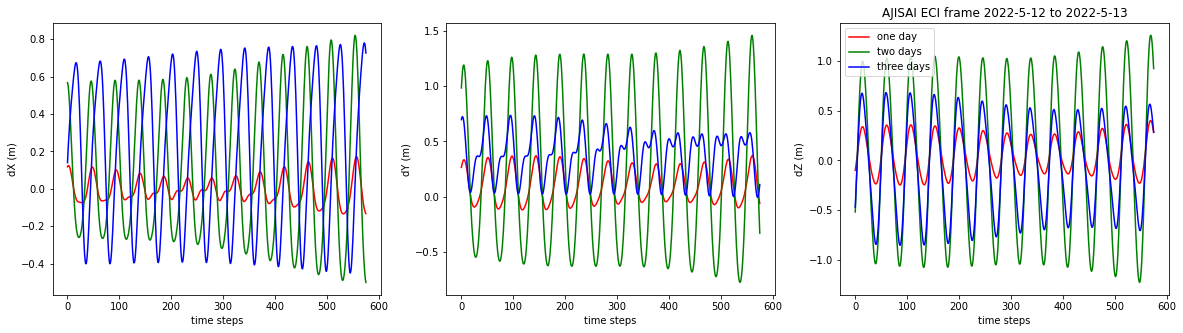

In [21]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("AJISAI ECI frame 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,aj_dX1,'r',label="one day")
ax1.plot(ts_12_to_13,aj_dX2,'g',label="two days")
ax1.plot(ts_12_to_13,aj_dX3,'b',label="three days")
ax2.plot(ts_12_to_13,aj_dY1,'r',label="one day")
ax2.plot(ts_12_to_13,aj_dY2,'g',label="two days")
ax2.plot(ts_12_to_13,aj_dY3,'b',label="three days")
ax3.plot(ts_12_to_13,aj_dZ1,'r',label="one day")
ax3.plot(ts_12_to_13,aj_dZ2,'g',label="two days")
ax3.plot(ts_12_to_13,aj_dZ3,'b',label="three days")


ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dX (m)")
ax2.set_ylabel("dY (m)")
ax3.set_ylabel("dZ (m)")
plt.legend()
plt.show()

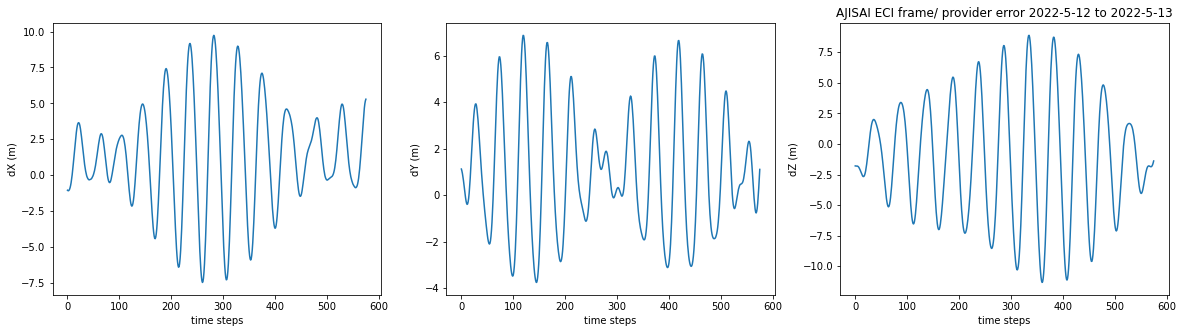

In [22]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("AJISAI ECI frame/ provider error 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,aj_dXpr)
ax2.plot(ts_12_to_13,aj_dYpr)
ax3.plot(ts_12_to_13,aj_dZpr)


ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dX (m)")
ax2.set_ylabel("dY (m)")
ax3.set_ylabel("dZ (m)")
plt.show()

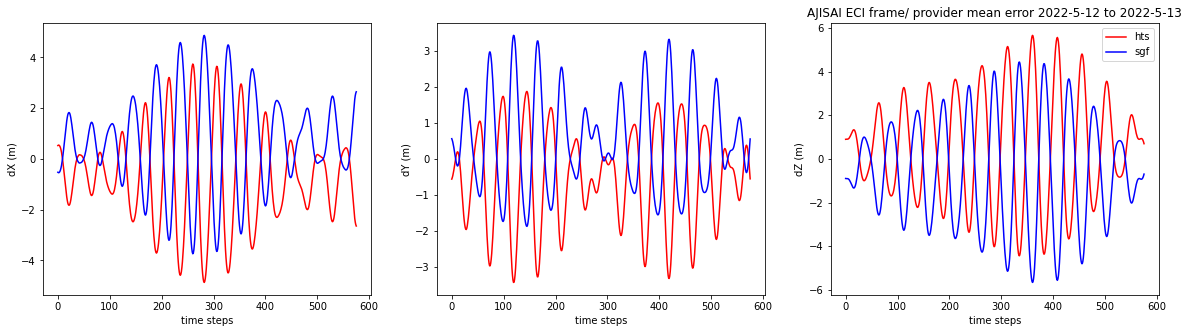

In [23]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("AJISAI ECI frame/ provider mean error 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,aj_dXhts,"r",label="hts")
ax2.plot(ts_12_to_13,aj_dYhts,"r",label="hts")
ax3.plot(ts_12_to_13,aj_dZhts,"r",label="hts")

ax1.plot(ts_12_to_13,aj_dXsgf,"b",label="sgf")
ax2.plot(ts_12_to_13,aj_dYsgf,"b",label="sgf")
ax3.plot(ts_12_to_13,aj_dZsgf,"b",label="sgf")


ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dX (m)")
ax2.set_ylabel("dY (m)")
ax3.set_ylabel("dZ (m)")
plt.legend()
plt.show()

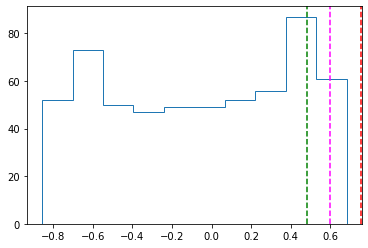

In [83]:
distr = aj_dZ3
plt.hist(distr,density=False,histtype='step')
plt.axvline(abs(statistics.mean(distr))+1.5*statistics.pstdev(distr),color="r",linestyle="--")
plt.axvline(max(distr)/np.sqrt(2),color='g',linestyle="--")
plt.axvline(np.percentile(distr,95),color="magenta",linestyle="--")
#plt.hist(aj_dX2)
#plt.hist(aj_dX1)
plt.show()

In [70]:
np.percentile(aj_dI1,50)

0.22483608007855121

### RIC frame

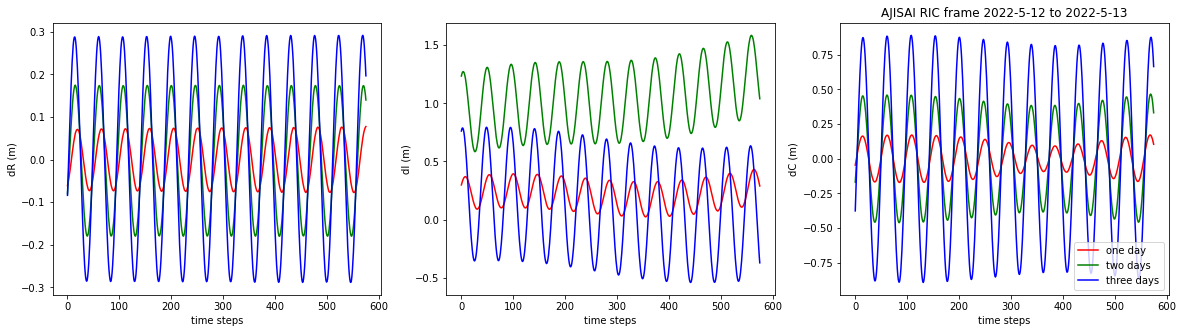

In [53]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("AJISAI RIC frame 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,aj_dR1,'r',label="one day")
ax1.plot(ts_12_to_13,aj_dR2,'g',label="two days")
ax1.plot(ts_12_to_13,aj_dR3,'b',label="three days")
ax2.plot(ts_12_to_13,aj_dI1,'r',label="one day")
ax2.plot(ts_12_to_13,aj_dI2,'g',label="two days")
ax2.plot(ts_12_to_13,aj_dI3,'b',label="three days")
ax3.plot(ts_12_to_13,aj_dC1,'r',label="one day")
ax3.plot(ts_12_to_13,aj_dC2,'g',label="two days")
ax3.plot(ts_12_to_13,aj_dC3,'b',label="three days")

ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dR (m)")
ax2.set_ylabel("dI (m)")
ax3.set_ylabel("dC (m)")
plt.legend()
plt.show()

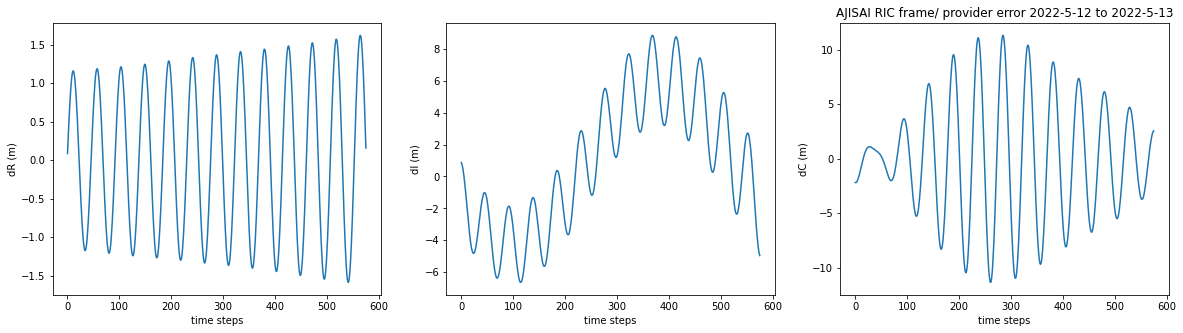

In [155]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("AJISAI RIC frame/ provider error 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,aj_dRpr)
ax2.plot(ts_12_to_13,aj_dIpr)
ax3.plot(ts_12_to_13,aj_dCpr)


ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dR (m)")
ax2.set_ylabel("dI (m)")
ax3.set_ylabel("dC (m)")
plt.show()

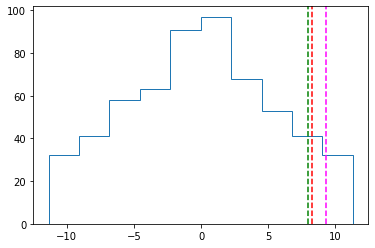

In [72]:
distr = aj_dCpr
plt.hist(distr,density=False,histtype='step')
plt.axvline(abs(statistics.mean(distr))+1.5*statistics.pstdev(distr),color="r",linestyle="--")
plt.axvline(max(distr)/np.sqrt(2),color='g',linestyle="--")
plt.axvline(np.percentile(distr,95),color='magenta',linestyle="--")
plt.show()

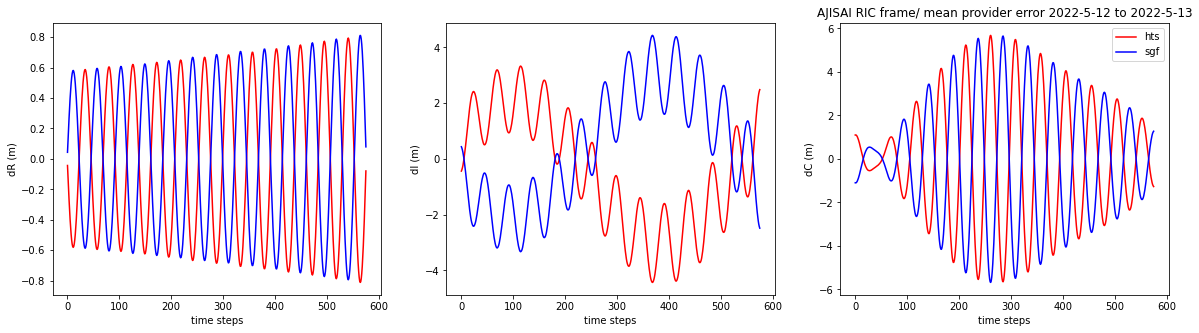

In [232]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("AJISAI RIC frame/ mean provider error 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,aj_dRhts,"r",label="hts")
ax2.plot(ts_12_to_13,aj_dIhts,"r",label="hts")
ax3.plot(ts_12_to_13,aj_dChts,"r",label="hts")

ax1.plot(ts_12_to_13,aj_dRsgf,"b",label="sgf")
ax2.plot(ts_12_to_13,aj_dIsgf,"b",label="sgf")
ax3.plot(ts_12_to_13,aj_dCsgf,"b",label="sgf")


ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dR (m)")
ax2.set_ylabel("dI (m)")
ax3.set_ylabel("dC (m)")
plt.legend()
plt.show()

In [213]:
print("In-track one day error:", abs(round(statistics.mean(aj_dI1),3))+round(statistics.pstdev(aj_dI1),3), "m")
print("In-track two days error:", abs(round(statistics.mean(aj_dI2),3))+round(statistics.pstdev(aj_dI2),3), "m")
print("In-track three days error:", abs(round(statistics.mean(aj_dI3),3))+round(statistics.pstdev(aj_dI3),3), "m")

In-track one day error: 0.333 m
In-track two days error: 1.312 m
In-track three days error: 0.544 m


In [214]:
print("In-track provider error:", abs(round(statistics.mean(aj_dIpr),3)) + round(statistics.pstdev(aj_dIpr),3), "m")

In-track provider error: 5.045999999999999 m


## LARES

In [78]:
la_ninth = '/Users/gkeramidas/Projects/learning/truth/L4884/lares_cpf_220509_12901.sgf'
la_tenth = '/Users/gkeramidas/Projects/learning/truth/L4884/lares_cpf_220510_13001.sgf'
la_eleventh = '/Users/gkeramidas/Projects/learning/truth/L4884/lares_cpf_220511_13101.sgf'
la_twelveth = '/Users/gkeramidas/Projects/learning/truth/L4884/lares_cpf_220512_13201.sgf'

In [79]:
la_nin_eph = TruthEphemerisManager([la_ninth])
la_ten_eph = TruthEphemerisManager([la_tenth])
la_ele_eph = TruthEphemerisManager([la_eleventh])
la_twe_eph = TruthEphemerisManager([la_twelveth])

In [121]:
la_12_hts = '/Users/gkeramidas/Projects/learning/truth/L4884/lares_cpf_220512_13201.hts'
la_hts_eph = TruthEphemerisManager([la_12_hts])

In [80]:
la_dX1,la_dX2,la_dX3,la_dY1,la_dY2,la_dY3,la_dZ1,la_dZ2,la_dZ3,la_dR1,la_dR2,la_dR3,la_dI1,la_dI2,la_dI3,la_dC1,la_dC2,la_dC3 = differences(la_twe_eph,la_ele_eph,la_ten_eph,la_nin_eph,epoch_unix)

In [122]:
la_dXpr,la_dYpr,la_dZpr,la_dRpr,la_dIpr,la_dCpr = diff_providers(la_hts_eph,la_twe_eph,epoch_unix)

In [233]:
la_dXhts,la_dYhts,la_dZhts,la_dRhts,la_dIhts,la_dChts, la_dXsgf,la_dYsgf,la_dZsgf,la_dRsgf,la_dIsgf,la_dCsgf = prov_mean_diff(la_hts_eph,la_twe_eph,epoch_unix)

### ECI frame

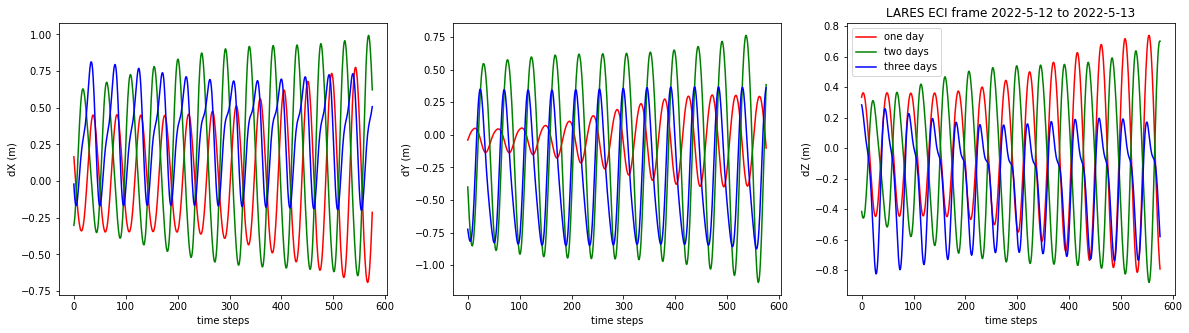

In [156]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("LARES ECI frame 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,la_dX1,'r',label="one day")
ax1.plot(ts_12_to_13,la_dX2,'g',label="two days")
ax1.plot(ts_12_to_13,la_dX3,'b',label="three days")
ax2.plot(ts_12_to_13,la_dY1,'r',label="one day")
ax2.plot(ts_12_to_13,la_dY2,'g',label="two days")
ax2.plot(ts_12_to_13,la_dY3,'b',label="three days")
ax3.plot(ts_12_to_13,la_dZ1,'r',label="one day")
ax3.plot(ts_12_to_13,la_dZ2,'g',label="two days")
ax3.plot(ts_12_to_13,la_dZ3,'b',label="three days")


ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dX (m)")
ax2.set_ylabel("dY (m)")
ax3.set_ylabel("dZ (m)")
plt.legend()
plt.show()

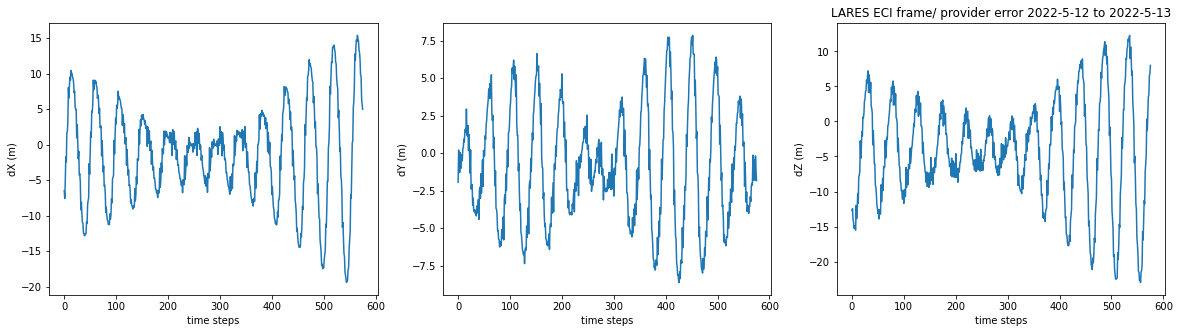

In [157]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("LARES ECI frame/ provider error 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,la_dXpr)
ax2.plot(ts_12_to_13,la_dYpr)
ax3.plot(ts_12_to_13,la_dZpr)


ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dX (m)")
ax2.set_ylabel("dY (m)")
ax3.set_ylabel("dZ (m)")
plt.show()

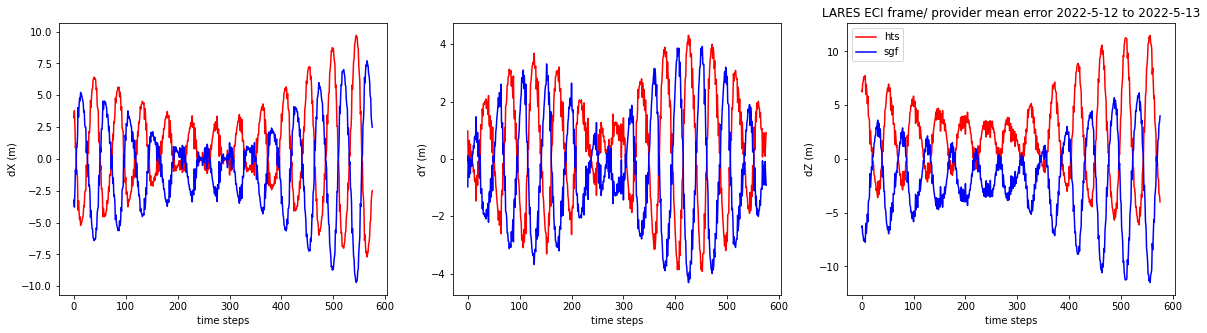

In [234]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("LARES ECI frame/ provider mean error 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,la_dXhts,"r",label="hts")
ax2.plot(ts_12_to_13,la_dYhts,"r",label="hts")
ax3.plot(ts_12_to_13,la_dZhts,"r",label="hts")

ax1.plot(ts_12_to_13,la_dXsgf,"b",label="sgf")
ax2.plot(ts_12_to_13,la_dYsgf,"b",label="sgf")
ax3.plot(ts_12_to_13,la_dZsgf,"b",label="sgf")


ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dX (m)")
ax2.set_ylabel("dY (m)")
ax3.set_ylabel("dZ (m)")
plt.legend()
plt.show()

### RIC frame

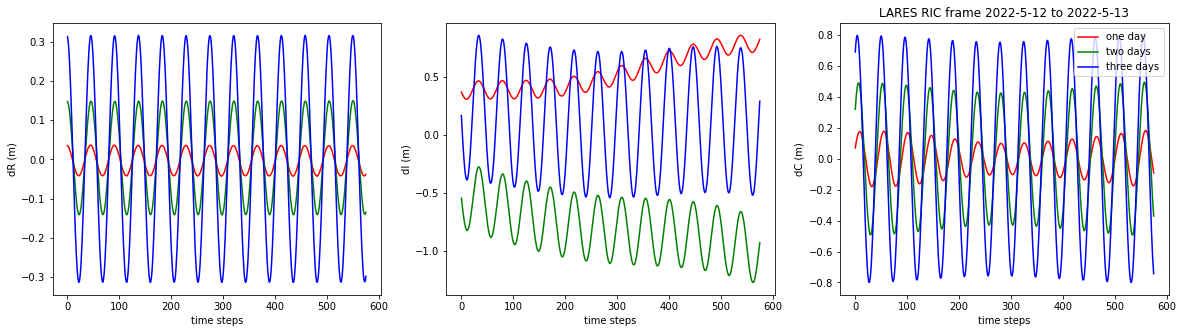

In [158]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("LARES RIC frame 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,la_dR1,'r',label="one day")
ax1.plot(ts_12_to_13,la_dR2,'g',label="two days")
ax1.plot(ts_12_to_13,la_dR3,'b',label="three days")
ax2.plot(ts_12_to_13,la_dI1,'r',label="one day")
ax2.plot(ts_12_to_13,la_dI2,'g',label="two days")
ax2.plot(ts_12_to_13,la_dI3,'b',label="three days")
ax3.plot(ts_12_to_13,la_dC1,'r',label="one day")
ax3.plot(ts_12_to_13,la_dC2,'g',label="two days")
ax3.plot(ts_12_to_13,la_dC3,'b',label="three days")

ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dR (m)")
ax2.set_ylabel("dI (m)")
ax3.set_ylabel("dC (m)")
plt.legend()
plt.show()

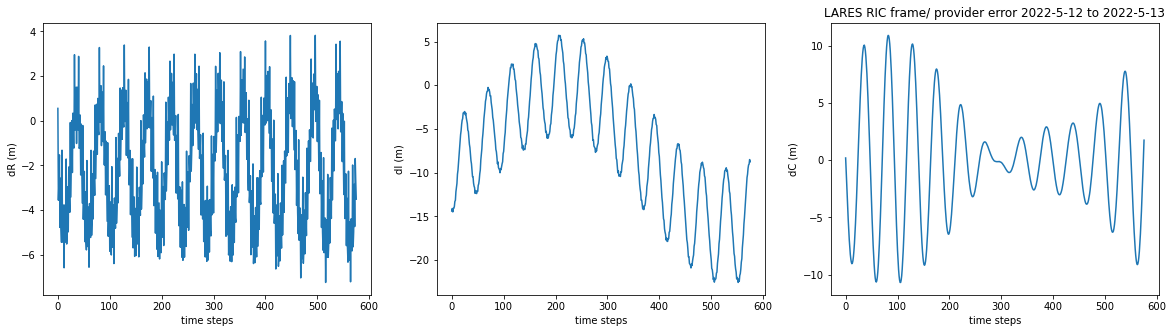

In [159]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("LARES RIC frame/ provider error 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,la_dRpr)
ax2.plot(ts_12_to_13,la_dIpr)
ax3.plot(ts_12_to_13,la_dCpr)


ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dR (m)")
ax2.set_ylabel("dI (m)")
ax3.set_ylabel("dC (m)")
plt.show()

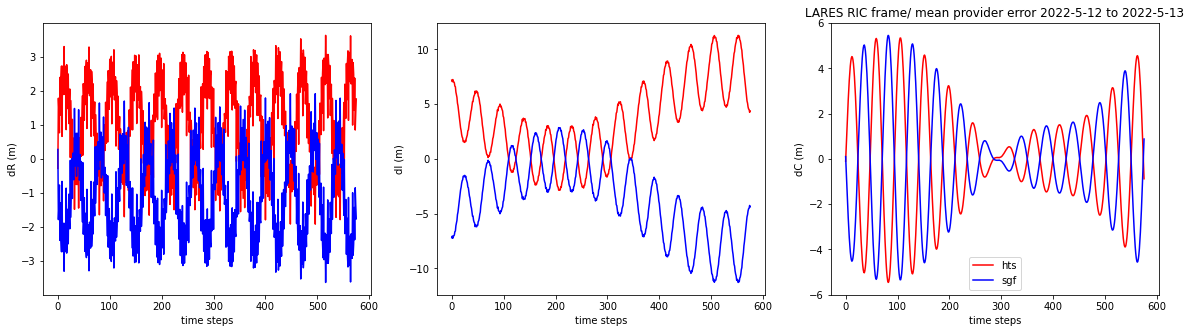

In [235]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("LARES RIC frame/ mean provider error 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,la_dRhts,"r",label="hts")
ax2.plot(ts_12_to_13,la_dIhts,"r",label="hts")
ax3.plot(ts_12_to_13,la_dChts,"r",label="hts")

ax1.plot(ts_12_to_13,la_dRsgf,"b",label="sgf")
ax2.plot(ts_12_to_13,la_dIsgf,"b",label="sgf")
ax3.plot(ts_12_to_13,la_dCsgf,"b",label="sgf")


ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dR (m)")
ax2.set_ylabel("dI (m)")
ax3.set_ylabel("dC (m)")
plt.legend()
plt.show()

In [215]:
print("In-track one day error:", abs(round(statistics.mean(la_dI1),3))+round(statistics.pstdev(la_dI1),3), "m")
print("In-track two days error:", abs(round(statistics.mean(la_dI2),3))+round(statistics.pstdev(la_dI2),3), "m")
print("In-track three days error:", abs(round(statistics.mean(la_dI3),3))+round(statistics.pstdev(la_dI3),3), "m")

In-track one day error: 0.6940000000000001 m
In-track two days error: 1.0290000000000001 m
In-track three days error: 0.563 m


In [210]:
print("In-track provider error:", abs(round(statistics.mean(la_dIpr),3))+round(statistics.pstdev(la_dIpr),3), "m")

In-track provider error: 14.256 m


## LARETS

In [83]:
lrts_ninth = '/Users/gkeramidas/Projects/learning/truth/L2486/larets_cpf_220509_12901.sgf'
lrts_tenth = '/Users/gkeramidas/Projects/learning/truth/L2486/larets_cpf_220510_13001.sgf'
lrts_eleventh = '/Users/gkeramidas/Projects/learning/truth/L2486/larets_cpf_220511_13101.sgf'
lrts_twelveth = '/Users/gkeramidas/Projects/learning/truth/L2486/larets_cpf_220512_13201.sgf'

In [84]:
lrts_nin_eph = TruthEphemerisManager([lrts_ninth])
lrts_ten_eph = TruthEphemerisManager([lrts_tenth])
lrts_ele_eph = TruthEphemerisManager([lrts_eleventh])
lrts_twe_eph = TruthEphemerisManager([lrts_twelveth])

In [126]:
lrts_12_hts = '/Users/gkeramidas/Projects/learning/truth/L2486/larets_cpf_220512_13201.hts'
lrts_hts_eph = TruthEphemerisManager([lrts_12_hts])

In [85]:
lrts_dX1,lrts_dX2,lrts_dX3,lrts_dY1,lrts_dY2,lrts_dY3,lrts_dZ1,lrts_dZ2,lrts_dZ3,lrts_dR1,lrts_dR2,lrts_dR3,lrts_dI1,lrts_dI2,lrts_dI3,lrts_dC1,lrts_dC2,lrts_dC3 = differences(lrts_twe_eph,lrts_ele_eph,lrts_ten_eph,lrts_nin_eph,epoch_unix)

In [127]:
lrts_dXpr,lrts_dYpr,lrts_dZpr,lrts_dRpr,lrts_dIpr,lrts_dCpr = diff_providers(lrts_hts_eph,lrts_twe_eph,epoch_unix)

In [236]:
lrts_dXhts,lrts_dYhts,lrts_dZhts,lrts_dRhts,lrts_dIhts,lrts_dChts, lrts_dXsgf,lrts_dYsgf,lrts_dZsgf,lrts_dRsgf,lrts_dIsgf,lrts_dCsgf = prov_mean_diff(lrts_hts_eph,lrts_twe_eph,epoch_unix)

### ECI frame

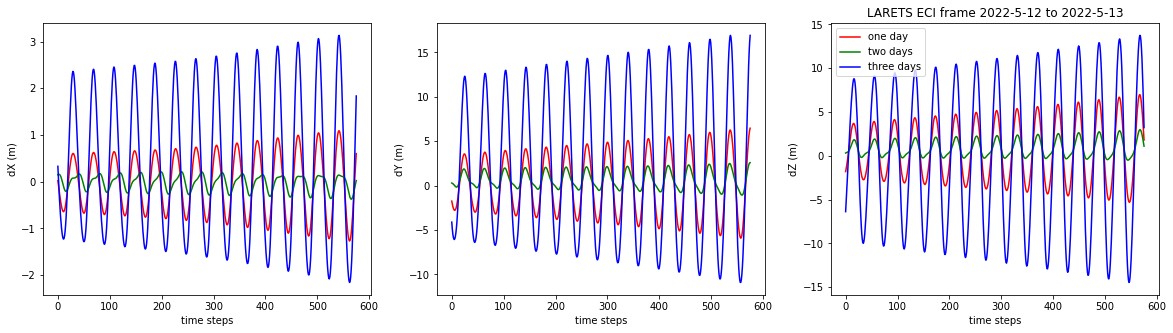

In [160]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("LARETS ECI frame 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,lrts_dX1,'r',label="one day")
ax1.plot(ts_12_to_13,lrts_dX2,'g',label="two days")
ax1.plot(ts_12_to_13,lrts_dX3,'b',label="three days")
ax2.plot(ts_12_to_13,lrts_dY1,'r',label="one day")
ax2.plot(ts_12_to_13,lrts_dY2,'g',label="two days")
ax2.plot(ts_12_to_13,lrts_dY3,'b',label="three days")
ax3.plot(ts_12_to_13,lrts_dZ1,'r',label="one day")
ax3.plot(ts_12_to_13,lrts_dZ2,'g',label="two days")
ax3.plot(ts_12_to_13,lrts_dZ3,'b',label="three days")


ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dX (m)")
ax2.set_ylabel("dY (m)")
ax3.set_ylabel("dZ (m)")
plt.legend()
plt.show()

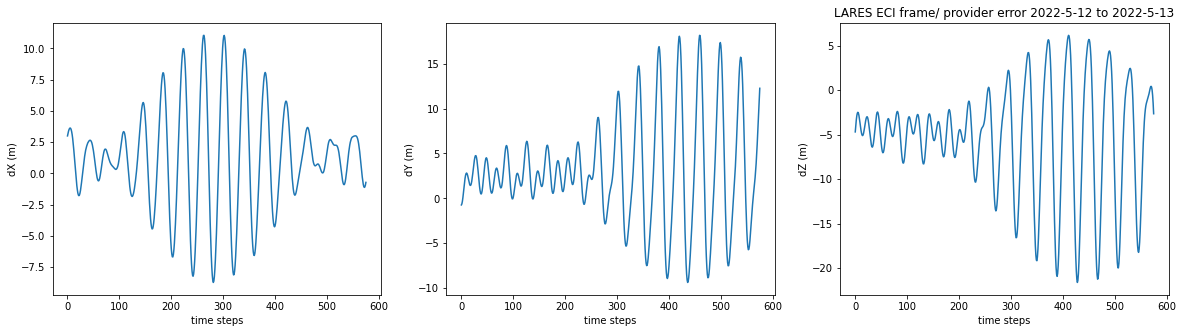

In [161]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("LARES ECI frame/ provider error 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,lrts_dXpr)
ax2.plot(ts_12_to_13,lrts_dYpr)
ax3.plot(ts_12_to_13,lrts_dZpr)


ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dX (m)")
ax2.set_ylabel("dY (m)")
ax3.set_ylabel("dZ (m)")
plt.show()

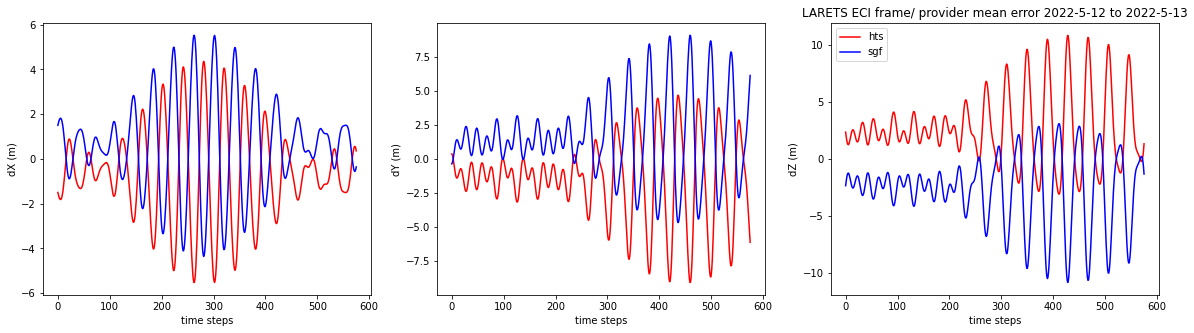

In [237]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("LARETS ECI frame/ provider mean error 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,lrts_dXhts,"r",label="hts")
ax2.plot(ts_12_to_13,lrts_dYhts,"r",label="hts")
ax3.plot(ts_12_to_13,lrts_dZhts,"r",label="hts")

ax1.plot(ts_12_to_13,lrts_dXsgf,"b",label="sgf")
ax2.plot(ts_12_to_13,lrts_dYsgf,"b",label="sgf")
ax3.plot(ts_12_to_13,lrts_dZsgf,"b",label="sgf")


ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dX (m)")
ax2.set_ylabel("dY (m)")
ax3.set_ylabel("dZ (m)")
plt.legend()
plt.show()

### RIC frame

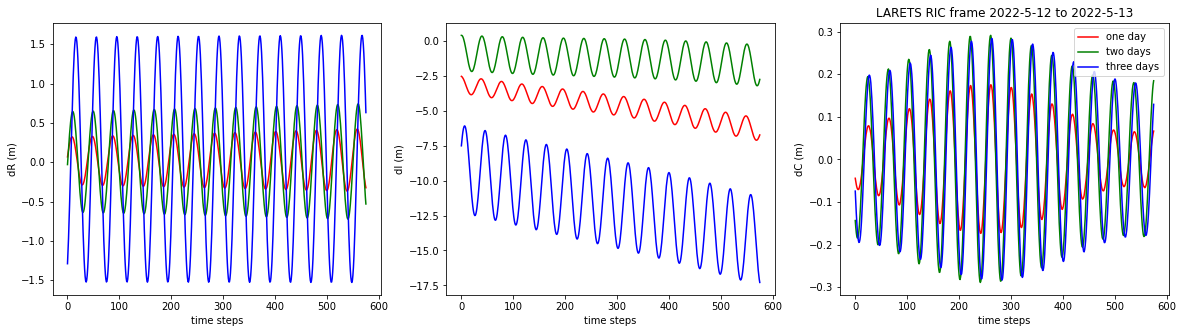

In [162]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("LARETS RIC frame 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,lrts_dR1,'r',label="one day")
ax1.plot(ts_12_to_13,lrts_dR2,'g',label="two days")
ax1.plot(ts_12_to_13,lrts_dR3,'b',label="three days")
ax2.plot(ts_12_to_13,lrts_dI1,'r',label="one day")
ax2.plot(ts_12_to_13,lrts_dI2,'g',label="two days")
ax2.plot(ts_12_to_13,lrts_dI3,'b',label="three days")
ax3.plot(ts_12_to_13,lrts_dC1,'r',label="one day")
ax3.plot(ts_12_to_13,lrts_dC2,'g',label="two days")
ax3.plot(ts_12_to_13,lrts_dC3,'b',label="three days")

ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dR (m)")
ax2.set_ylabel("dI (m)")
ax3.set_ylabel("dC (m)")
plt.legend()
plt.show()

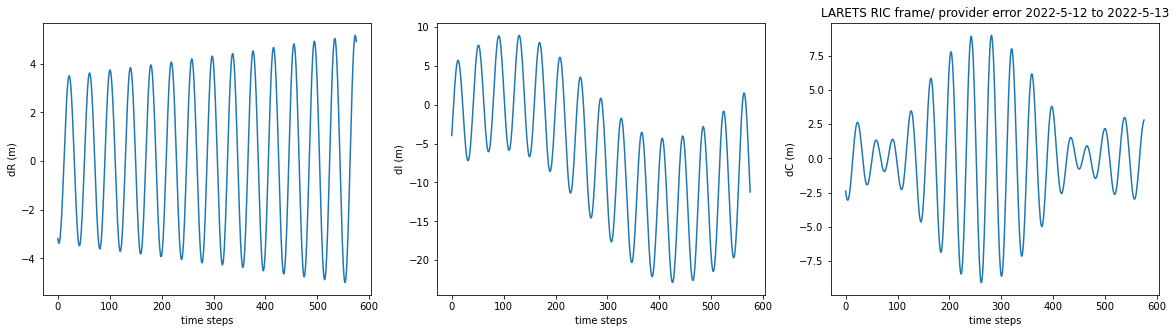

In [163]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("LARETS RIC frame/ provider error 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,lrts_dRpr)
ax2.plot(ts_12_to_13,lrts_dIpr)
ax3.plot(ts_12_to_13,lrts_dCpr)


ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dR (m)")
ax2.set_ylabel("dI (m)")
ax3.set_ylabel("dC (m)")
plt.show()

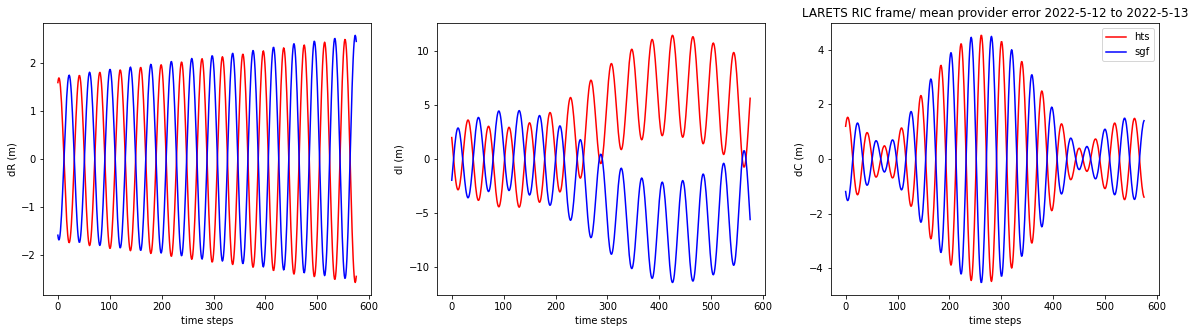

In [238]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("LARETS RIC frame/ mean provider error 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,lrts_dRhts,"r",label="hts")
ax2.plot(ts_12_to_13,lrts_dIhts,"r",label="hts")
ax3.plot(ts_12_to_13,lrts_dChts,"r",label="hts")

ax1.plot(ts_12_to_13,lrts_dRsgf,"b",label="sgf")
ax2.plot(ts_12_to_13,lrts_dIsgf,"b",label="sgf")
ax3.plot(ts_12_to_13,lrts_dCsgf,"b",label="sgf")


ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dR (m)")
ax2.set_ylabel("dI (m)")
ax3.set_ylabel("dC (m)")
plt.legend()
plt.show()

In [216]:
print("In-track one day error:", abs(round(statistics.mean(lrts_dI1),3))+round(statistics.pstdev(lrts_dI1),3), "m")
print("In-track two days error:", abs(round(statistics.mean(lrts_dI2),3))+round(statistics.pstdev(lrts_dI2),3), "m")
print("In-track three days error:", abs(round(statistics.mean(lrts_dI3),3))+round(statistics.pstdev(lrts_dI3),3), "m")

In-track one day error: 5.668 m
In-track two days error: 2.2560000000000002 m
In-track three days error: 14.293000000000001 m


In [217]:
print("In-track provider error:", abs(round(statistics.mean(lrts_dIpr),3))+round(statistics.pstdev(lrts_dIpr),3), "m")

In-track provider error: 14.379999999999999 m


## STELLA

In [88]:
st_ninth = '/Users/gkeramidas/Projects/learning/truth/L5011/stella_cpf_220509_12901.sgf'
st_tenth = '/Users/gkeramidas/Projects/learning/truth/L5011/stella_cpf_220510_13001.sgf'
st_eleventh = '/Users/gkeramidas/Projects/learning/truth/L5011/stella_cpf_220511_13101.sgf'
st_twelveth = '/Users/gkeramidas/Projects/learning/truth/L5011/stella_cpf_220512_13201.sgf'

In [89]:
st_nin_eph = TruthEphemerisManager([st_ninth])
st_ten_eph = TruthEphemerisManager([st_tenth])
st_ele_eph = TruthEphemerisManager([st_eleventh])
st_twe_eph = TruthEphemerisManager([st_twelveth])

In [131]:
st_12_hts = '/Users/gkeramidas/Projects/learning/truth/L5011/stella_cpf_220512_13201.hts'
st_hts_eph = TruthEphemerisManager([st_12_hts])

In [90]:
st_dX1,st_dX2,st_dX3,st_dY1,st_dY2,st_dY3,st_dZ1,st_dZ2,st_dZ3,st_dR1,st_dR2,st_dR3,st_dI1,st_dI2,st_dI3,st_dC1,st_dC2,st_dC3 = differences(st_twe_eph,st_ele_eph,st_ten_eph,st_nin_eph,epoch_unix)

In [132]:
st_dXpr,st_dYpr,st_dZpr,st_dRpr,st_dIpr,st_dCpr = diff_providers(st_hts_eph,st_twe_eph,epoch_unix)

In [239]:
st_dXhts,st_dYhts,st_dZhts,st_dRhts,st_dIhts,st_dChts, st_dXsgf,st_dYsgf,st_dZsgf,st_dRsgf,st_dIsgf,st_dCsgf = prov_mean_diff(st_hts_eph,st_twe_eph,epoch_unix)

### ECI frame

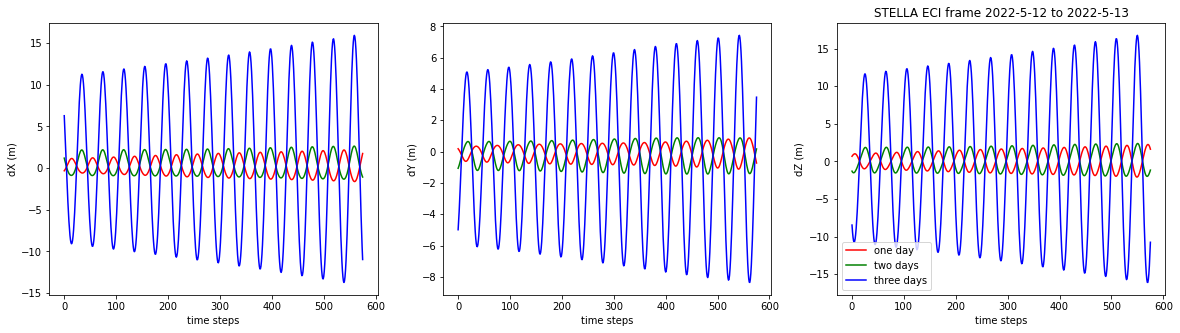

In [164]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("STELLA ECI frame 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,st_dX1,'r',label="one day")
ax1.plot(ts_12_to_13,st_dX2,'g',label="two days")
ax1.plot(ts_12_to_13,st_dX3,'b',label="three days")
ax2.plot(ts_12_to_13,st_dY1,'r',label="one day")
ax2.plot(ts_12_to_13,st_dY2,'g',label="two days")
ax2.plot(ts_12_to_13,st_dY3,'b',label="three days")
ax3.plot(ts_12_to_13,st_dZ1,'r',label="one day")
ax3.plot(ts_12_to_13,st_dZ2,'g',label="two days")
ax3.plot(ts_12_to_13,st_dZ3,'b',label="three days")


ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dX (m)")
ax2.set_ylabel("dY (m)")
ax3.set_ylabel("dZ (m)")
plt.legend()
plt.show()

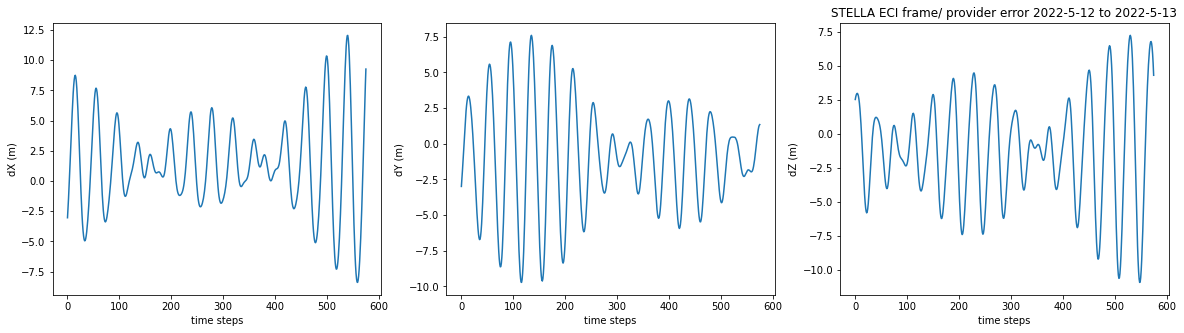

In [165]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("STELLA ECI frame/ provider error 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,st_dXpr)
ax2.plot(ts_12_to_13,st_dYpr)
ax3.plot(ts_12_to_13,st_dZpr)


ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dX (m)")
ax2.set_ylabel("dY (m)")
ax3.set_ylabel("dZ (m)")
plt.show()

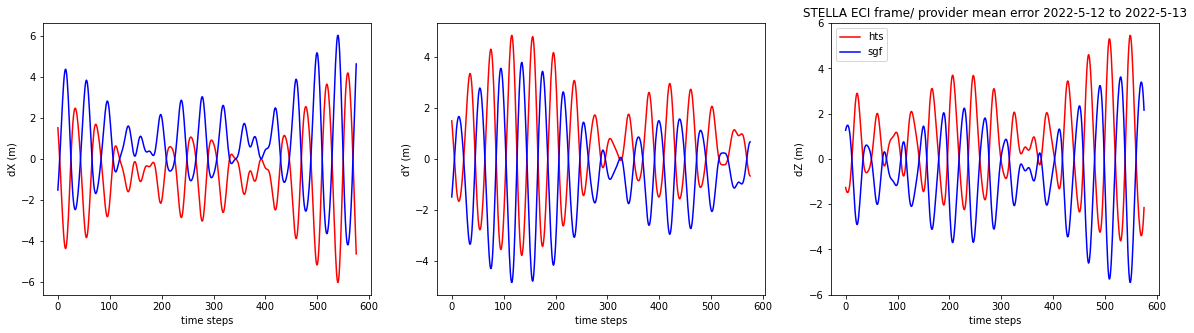

In [240]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("STELLA ECI frame/ provider mean error 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,st_dXhts,"r",label="hts")
ax2.plot(ts_12_to_13,st_dYhts,"r",label="hts")
ax3.plot(ts_12_to_13,st_dZhts,"r",label="hts")

ax1.plot(ts_12_to_13,st_dXsgf,"b",label="sgf")
ax2.plot(ts_12_to_13,st_dYsgf,"b",label="sgf")
ax3.plot(ts_12_to_13,st_dZsgf,"b",label="sgf")


ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dX (m)")
ax2.set_ylabel("dY (m)")
ax3.set_ylabel("dZ (m)")
plt.legend()
plt.show()

### RIC frame

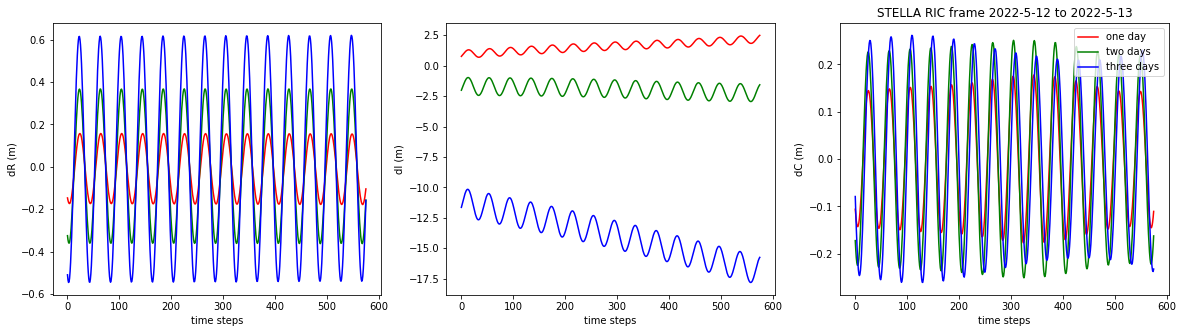

In [166]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("STELLA RIC frame 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,st_dR1,'r',label="one day")
ax1.plot(ts_12_to_13,st_dR2,'g',label="two days")
ax1.plot(ts_12_to_13,st_dR3,'b',label="three days")
ax2.plot(ts_12_to_13,st_dI1,'r',label="one day")
ax2.plot(ts_12_to_13,st_dI2,'g',label="two days")
ax2.plot(ts_12_to_13,st_dI3,'b',label="three days")
ax3.plot(ts_12_to_13,st_dC1,'r',label="one day")
ax3.plot(ts_12_to_13,st_dC2,'g',label="two days")
ax3.plot(ts_12_to_13,st_dC3,'b',label="three days")

ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dR (m)")
ax2.set_ylabel("dI (m)")
ax3.set_ylabel("dC (m)")
plt.legend()
plt.show()

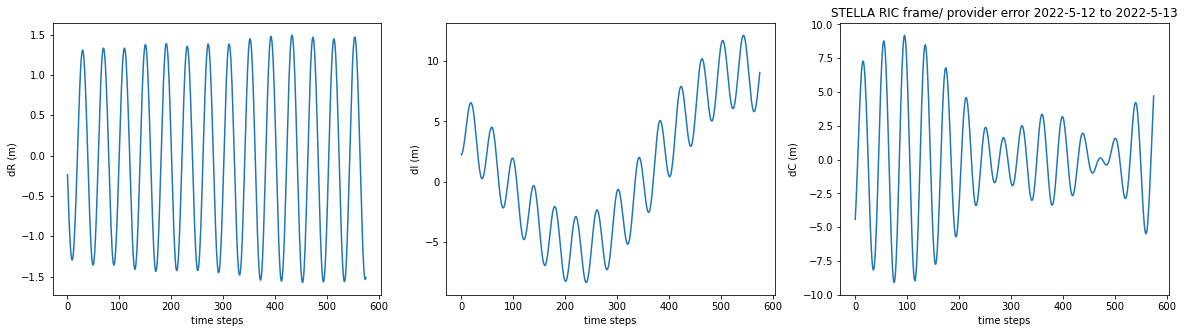

In [167]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("STELLA RIC frame/ provider error 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,st_dRpr)
ax2.plot(ts_12_to_13,st_dIpr)
ax3.plot(ts_12_to_13,st_dCpr)


ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dR (m)")
ax2.set_ylabel("dI (m)")
ax3.set_ylabel("dC (m)")
plt.show()

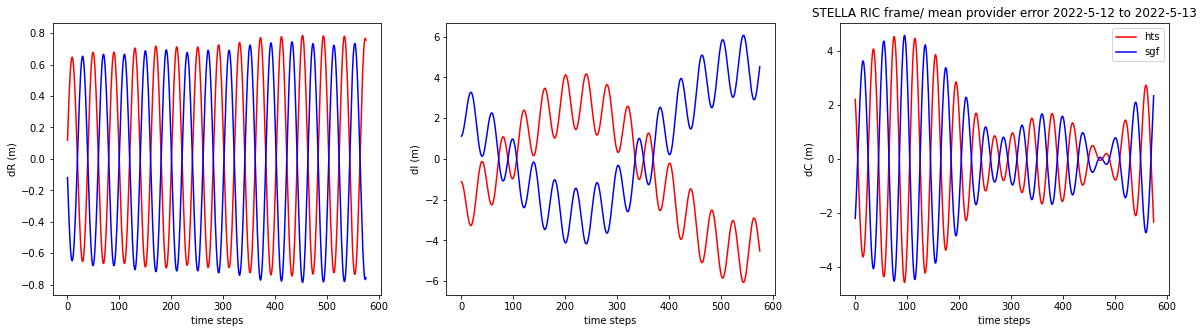

In [241]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("STELLA RIC frame/ mean provider error 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,st_dRhts,"r",label="hts")
ax2.plot(ts_12_to_13,st_dIhts,"r",label="hts")
ax3.plot(ts_12_to_13,st_dChts,"r",label="hts")

ax1.plot(ts_12_to_13,st_dRsgf,"b",label="sgf")
ax2.plot(ts_12_to_13,st_dIsgf,"b",label="sgf")
ax3.plot(ts_12_to_13,st_dCsgf,"b",label="sgf")


ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dR (m)")
ax2.set_ylabel("dI (m)")
ax3.set_ylabel("dC (m)")
plt.legend()
plt.show()

In [218]:
print("In-track one day error:", abs(round(statistics.mean(st_dI1),3))+round(statistics.pstdev(st_dI1),3), "m")
print("In-track two days error:", abs(round(statistics.mean(st_dI2),3))+round(statistics.pstdev(st_dI2),3), "m")
print("In-track three days error:", abs(round(statistics.mean(st_dI3),3))+round(statistics.pstdev(st_dI3),3), "m")

In-track one day error: 1.986 m
In-track two days error: 2.475 m
In-track three days error: 15.745999999999999 m


In [220]:
print("In-track provider error:", abs(round(statistics.mean(st_dIpr),3))+round(statistics.pstdev(st_dIpr),3), "m")

In-track provider error: 6.492 m


## Compare to SARAL

In [93]:
tr.dwld_data_for_target('L1471',[2022,5,12],4)

info Syncing ILRS truth data from S3 (9 files downloaded)


In [94]:
sa_ninth = '/Users/gkeramidas/Projects/learning/truth/L1471/saral_cpf_220509_12901.cne'
sa_tenth = '/Users/gkeramidas/Projects/learning/truth/L1471/saral_cpf_220510_13001.cne'
sa_eleventh = '/Users/gkeramidas/Projects/learning/truth/L1471/saral_cpf_220511_13101.cne'
sa_twelveth = '/Users/gkeramidas/Projects/learning/truth/L1471/saral_cpf_220512_13201.cne'

In [95]:
sa_nin_eph = TruthEphemerisManager([sa_ninth])
sa_ten_eph = TruthEphemerisManager([sa_tenth])
sa_ele_eph = TruthEphemerisManager([sa_eleventh])
sa_twe_eph = TruthEphemerisManager([sa_twelveth])

In [96]:
sa_dX1,sa_dX2,sa_dX3,sa_dY1,sa_dY2,sa_dY3,sa_dZ1,sa_dZ2,sa_dZ3,sa_dR1,sa_dR2,sa_dR3,sa_dI1,sa_dI2,sa_dI3,sa_dC1,sa_dC2,sa_dC3 = differences(sa_twe_eph,sa_ele_eph,sa_ten_eph,sa_nin_eph,epoch_unix)

### ECI frame.

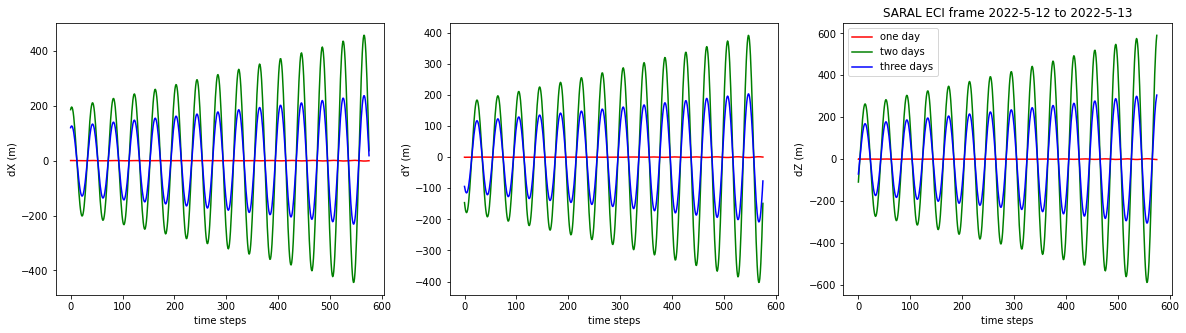

In [168]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("SARAL ECI frame 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,sa_dX1,'r',label="one day")
ax1.plot(ts_12_to_13,sa_dX2,'g',label="two days")
ax1.plot(ts_12_to_13,sa_dX3,'b',label="three days")
ax2.plot(ts_12_to_13,sa_dY1,'r',label="one day")
ax2.plot(ts_12_to_13,sa_dY2,'g',label="two days")
ax2.plot(ts_12_to_13,sa_dY3,'b',label="three days")
ax3.plot(ts_12_to_13,sa_dZ1,'r',label="one day")
ax3.plot(ts_12_to_13,sa_dZ2,'g',label="two days")
ax3.plot(ts_12_to_13,sa_dZ3,'b',label="three days")


ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dX (m)")
ax2.set_ylabel("dY (m)")
ax3.set_ylabel("dZ (m)")
plt.legend()
plt.show()

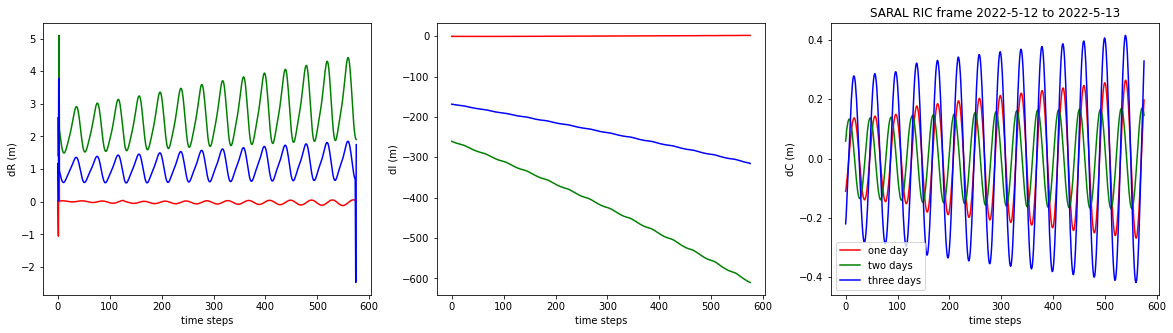

In [169]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("SARAL RIC frame 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,sa_dR1,'r',label="one day")
ax1.plot(ts_12_to_13,sa_dR2,'g',label="two days")
ax1.plot(ts_12_to_13,sa_dR3,'b',label="three days")
ax2.plot(ts_12_to_13,sa_dI1,'r',label="one day")
ax2.plot(ts_12_to_13,sa_dI2,'g',label="two days")
ax2.plot(ts_12_to_13,sa_dI3,'b',label="three days")
ax3.plot(ts_12_to_13,sa_dC1,'r',label="one day")
ax3.plot(ts_12_to_13,sa_dC2,'g',label="two days")
ax3.plot(ts_12_to_13,sa_dC3,'b',label="three days")

ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dR (m)")
ax2.set_ylabel("dI (m)")
ax3.set_ylabel("dC (m)")
plt.legend()
plt.show()

In [222]:
print("In-track one day error:", abs(round(statistics.mean(sa_dI1),3))+round(statistics.pstdev(sa_dI1),3), "m")
print("In-track two days error:", abs(round(statistics.mean(sa_dI2),3))+round(statistics.pstdev(sa_dI2),3), "m")
print("In-track three days error:", abs(round(statistics.mean(sa_dI3),3))+round(statistics.pstdev(sa_dI3),3), "m")

In-track one day error: 1.201 m
In-track two days error: 524.388 m
In-track three days error: 280.085 m


## Other dates for SARAL

In [146]:
epoch2SARAL_dt = datetime(2022,2,8)
epoch2SARAL_unix = (epoch2SARAL_dt-datetime(1970, 1, 1, 0, 0, 0)).total_seconds()

In [138]:
tr.dwld_data_for_target('L1471',[2022,2,8],4)

info Syncing ILRS truth data from S3 (9 files downloaded)


In [139]:
sa2_fifth = '/Users/gkeramidas/Projects/learning/truth/L1471/saral_cpf_220205_5361.cne'
sa2_sixth = '/Users/gkeramidas/Projects/learning/truth/L1471/saral_cpf_220206_5371.cne'
sa2_seventh = '/Users/gkeramidas/Projects/learning/truth/L1471/saral_cpf_220207_5381.cne'
sa2_eighth = '/Users/gkeramidas/Projects/learning/truth/L1471/saral_cpf_220208_5391.cne'

In [140]:
sa2_fiv_eph = TruthEphemerisManager([sa2_fifth])
sa2_six_eph = TruthEphemerisManager([sa2_sixth])
sa2_sev_eph = TruthEphemerisManager([sa2_seventh])
sa2_eight_eph = TruthEphemerisManager([sa2_eighth])

In [148]:
sa2_dX1,sa2_dX2,sa2_dX3,sa2_dY1,sa2_dY2,sa2_dY3,sa2_dZ1,sa2_dZ2,sa2_dZ3,sa2_dR1,sa2_dR2,sa2_dR3,sa2_dI1,sa2_dI2,sa2_dI3,sa2_dC1,sa2_dC2,sa2_dC3 = differences(sa2_eight_eph,sa2_sev_eph,sa2_six_eph,sa2_fiv_eph,epoch2SARAL_unix)

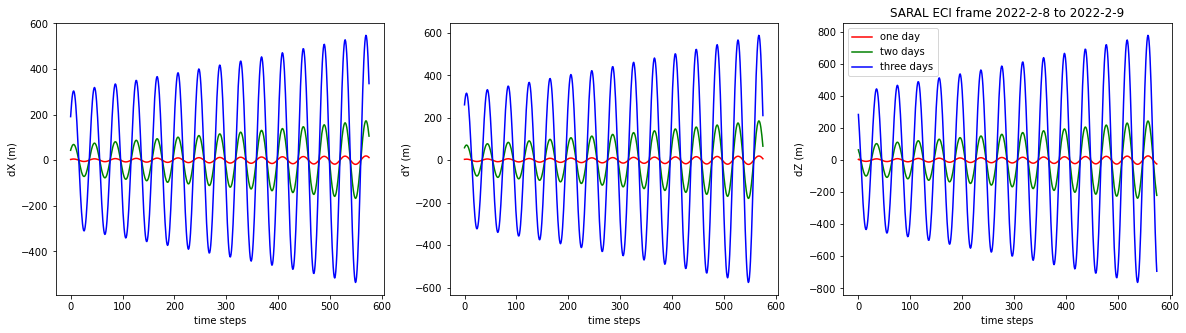

In [149]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("SARAL ECI frame 2022-2-8 to 2022-2-9")
ax1.plot(ts_12_to_13,sa2_dX1,'r',label="one day")
ax1.plot(ts_12_to_13,sa2_dX2,'g',label="two days")
ax1.plot(ts_12_to_13,sa2_dX3,'b',label="three days")
ax2.plot(ts_12_to_13,sa2_dY1,'r',label="one day")
ax2.plot(ts_12_to_13,sa2_dY2,'g',label="two days")
ax2.plot(ts_12_to_13,sa2_dY3,'b',label="three days")
ax3.plot(ts_12_to_13,sa2_dZ1,'r',label="one day")
ax3.plot(ts_12_to_13,sa2_dZ2,'g',label="two days")
ax3.plot(ts_12_to_13,sa2_dZ3,'b',label="three days")


ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dX (m)")
ax2.set_ylabel("dY (m)")
ax3.set_ylabel("dZ (m)")
plt.legend()
plt.show()

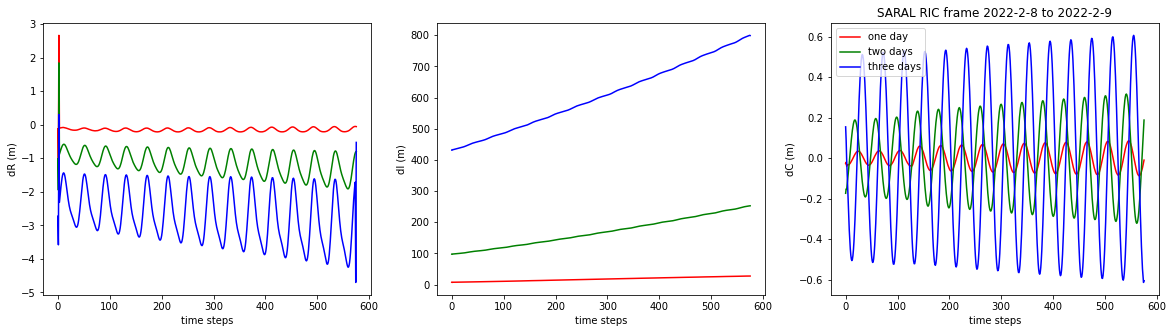

In [150]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("SARAL RIC frame 2022-2-8 to 2022-2-9")
ax1.plot(ts_12_to_13,sa2_dR1,'r',label="one day")
ax1.plot(ts_12_to_13,sa2_dR2,'g',label="two days")
ax1.plot(ts_12_to_13,sa2_dR3,'b',label="three days")
ax2.plot(ts_12_to_13,sa2_dI1,'r',label="one day")
ax2.plot(ts_12_to_13,sa2_dI2,'g',label="two days")
ax2.plot(ts_12_to_13,sa2_dI3,'b',label="three days")
ax3.plot(ts_12_to_13,sa2_dC1,'r',label="one day")
ax3.plot(ts_12_to_13,sa2_dC2,'g',label="two days")
ax3.plot(ts_12_to_13,sa2_dC3,'b',label="three days")

ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dR (m)")
ax2.set_ylabel("dI (m)")
ax3.set_ylabel("dC (m)")
plt.legend()
plt.show()

In [223]:
print("In-track one day error:", abs(round(statistics.mean(sa2_dI1),3))+round(statistics.pstdev(sa2_dI1),3), "m")
print("In-track two days error:", abs(round(statistics.mean(sa2_dI2),3))+round(statistics.pstdev(sa2_dI2),3), "m")
print("In-track three days error:", abs(round(statistics.mean(sa2_dI3),3))+round(statistics.pstdev(sa2_dI3),3), "m")

In-track one day error: 23.256 m
In-track two days error: 214.065 m
In-track three days error: 712.564 m


## CRYOSAT 2 (Leo Id:L2669)

In [170]:
tr.dwld_data_for_target('L2669',[2022,5,12],4)

info Syncing ILRS truth data from S3 (10 files downloaded)


In [171]:
cryo2_ninth = '/Users/gkeramidas/Projects/learning/truth/L2669/cryosat2_cpf_220509_12901.esa'
cryo2_tenth = '/Users/gkeramidas/Projects/learning/truth/L2669/cryosat2_cpf_220510_13001.esa'
cryo2_eleventh = '/Users/gkeramidas/Projects/learning/truth/L2669/cryosat2_cpf_220511_13101.esa'
cryo2_twelveth = '/Users/gkeramidas/Projects/learning/truth/L2669/cryosat2_cpf_220512_13201.esa'

In [172]:
cryo2_nin_eph = TruthEphemerisManager([cryo2_ninth])
cryo2_ten_eph = TruthEphemerisManager([cryo2_tenth])
cryo2_ele_eph = TruthEphemerisManager([cryo2_eleventh])
cryo2_twe_eph = TruthEphemerisManager([cryo2_twelveth])

In [173]:
cryo2_dX1,cryo2_dX2,cryo2_dX3,cryo2_dY1,cryo2_dY2,cryo2_dY3,cryo2_dZ1,cryo2_dZ2,cryo2_dZ3,cryo2_dR1,cryo2_dR2,cryo2_dR3,cryo2_dI1,cryo2_dI2,cryo2_dI3,cryo2_dC1,cryo2_dC2,cryo2_dC3 = differences(cryo2_twe_eph,cryo2_ele_eph,cryo2_ten_eph,cryo2_nin_eph,epoch_unix)

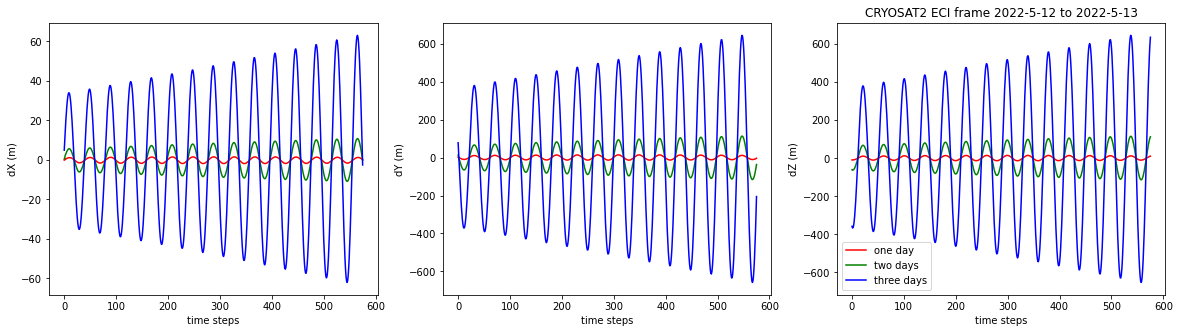

In [174]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("CRYOSAT2 ECI frame 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,cryo2_dX1,'r',label="one day")
ax1.plot(ts_12_to_13,cryo2_dX2,'g',label="two days")
ax1.plot(ts_12_to_13,cryo2_dX3,'b',label="three days")
ax2.plot(ts_12_to_13,cryo2_dY1,'r',label="one day")
ax2.plot(ts_12_to_13,cryo2_dY2,'g',label="two days")
ax2.plot(ts_12_to_13,cryo2_dY3,'b',label="three days")
ax3.plot(ts_12_to_13,cryo2_dZ1,'r',label="one day")
ax3.plot(ts_12_to_13,cryo2_dZ2,'g',label="two days")
ax3.plot(ts_12_to_13,cryo2_dZ3,'b',label="three days")


ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dX (m)")
ax2.set_ylabel("dY (m)")
ax3.set_ylabel("dZ (m)")
plt.legend()
plt.show()

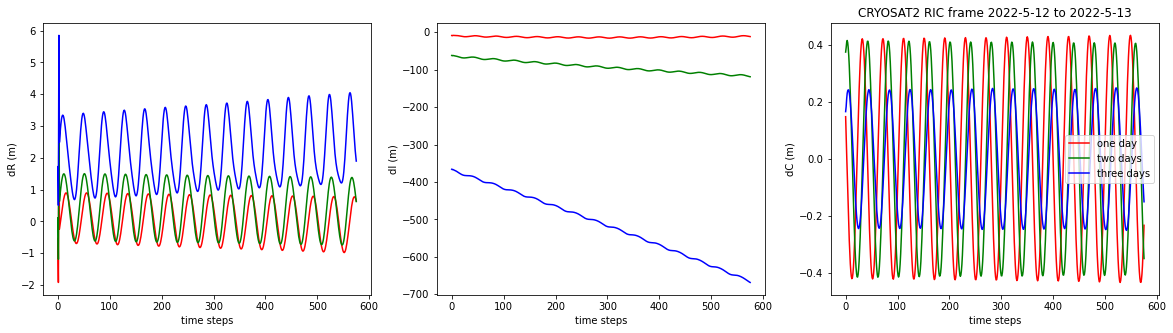

In [175]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("CRYOSAT2 RIC frame 2022-5-12 to 2022-5-13")
ax1.plot(ts_12_to_13,cryo2_dR1,'r',label="one day")
ax1.plot(ts_12_to_13,cryo2_dR2,'g',label="two days")
ax1.plot(ts_12_to_13,cryo2_dR3,'b',label="three days")
ax2.plot(ts_12_to_13,cryo2_dI1,'r',label="one day")
ax2.plot(ts_12_to_13,cryo2_dI2,'g',label="two days")
ax2.plot(ts_12_to_13,cryo2_dI3,'b',label="three days")
ax3.plot(ts_12_to_13,cryo2_dC1,'r',label="one day")
ax3.plot(ts_12_to_13,cryo2_dC2,'g',label="two days")
ax3.plot(ts_12_to_13,cryo2_dC3,'b',label="three days")

ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dR (m)")
ax2.set_ylabel("dI (m)")
ax3.set_ylabel("dC (m)")
plt.legend()
plt.show()

In [225]:
print("In-track one day error:", abs(round(statistics.mean(cryo2_dI1),3))+round(statistics.pstdev(cryo2_dI1),3), "m")
print("In-track two days error:", abs(round(statistics.mean(cryo2_dI2),3))+round(statistics.pstdev(cryo2_dI2),3), "m")
print("In-track three days error:", abs(round(statistics.mean(cryo2_dI3),3))+round(statistics.pstdev(cryo2_dI3),3), "m")

In-track one day error: 14.42 m
In-track two days error: 107.317 m
In-track three days error: 598.153 m


### Other day

In [177]:
tr.dwld_data_for_target('L2669',[2022,2,8],4)

info Syncing ILRS truth data from S3 (9 files downloaded)


In [178]:
cryo2_fifth = '/Users/gkeramidas/Projects/learning/truth/L2669/cryosat2_cpf_220205_5361.esa'
cryo2_sixth = '/Users/gkeramidas/Projects/learning/truth/L2669/cryosat2_cpf_220206_5371.esa'
cryo2_seventh = '/Users/gkeramidas/Projects/learning/truth/L2669/cryosat2_cpf_220207_5381.esa'
cryo2_eighth = '/Users/gkeramidas/Projects/learning/truth/L2669/cryosat2_cpf_220208_5391.esa'

In [179]:
cryo2_fiv_eph = TruthEphemerisManager([cryo2_fifth])
cryo2_six_eph = TruthEphemerisManager([cryo2_sixth])
cryo2_sev_eph = TruthEphemerisManager([cryo2_seventh])
cryo2_eight_eph = TruthEphemerisManager([cryo2_eighth])

In [180]:
cryo22_dX1,cryo22_dX2,cryo22_dX3,cryo22_dY1,cryo22_dY2,cryo22_dY3,cryo22_dZ1,cryo22_dZ2,cryo22_dZ3,cryo22_dR1,cryo22_dR2,cryo22_dR3,cryo22_dI1,cryo22_dI2,cryo22_dI3,cryo22_dC1,cryo22_dC2,cryo22_dC3 = differences(cryo2_eight_eph,cryo2_sev_eph,cryo2_six_eph,cryo2_fiv_eph,epoch2SARAL_unix)

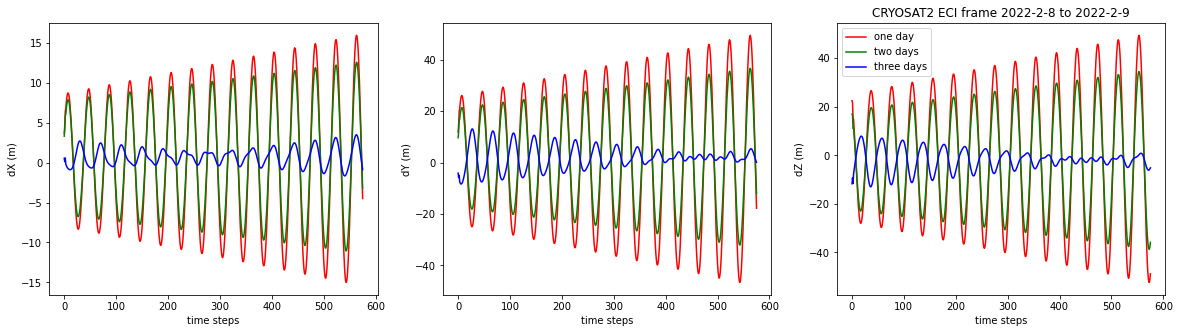

In [181]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("CRYOSAT2 ECI frame 2022-2-8 to 2022-2-9")
ax1.plot(ts_12_to_13,cryo22_dX1,'r',label="one day")
ax1.plot(ts_12_to_13,cryo22_dX2,'g',label="two days")
ax1.plot(ts_12_to_13,cryo22_dX3,'b',label="three days")
ax2.plot(ts_12_to_13,cryo22_dY1,'r',label="one day")
ax2.plot(ts_12_to_13,cryo22_dY2,'g',label="two days")
ax2.plot(ts_12_to_13,cryo22_dY3,'b',label="three days")
ax3.plot(ts_12_to_13,cryo22_dZ1,'r',label="one day")
ax3.plot(ts_12_to_13,cryo22_dZ2,'g',label="two days")
ax3.plot(ts_12_to_13,cryo22_dZ3,'b',label="three days")


ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dX (m)")
ax2.set_ylabel("dY (m)")
ax3.set_ylabel("dZ (m)")
plt.legend()
plt.show()

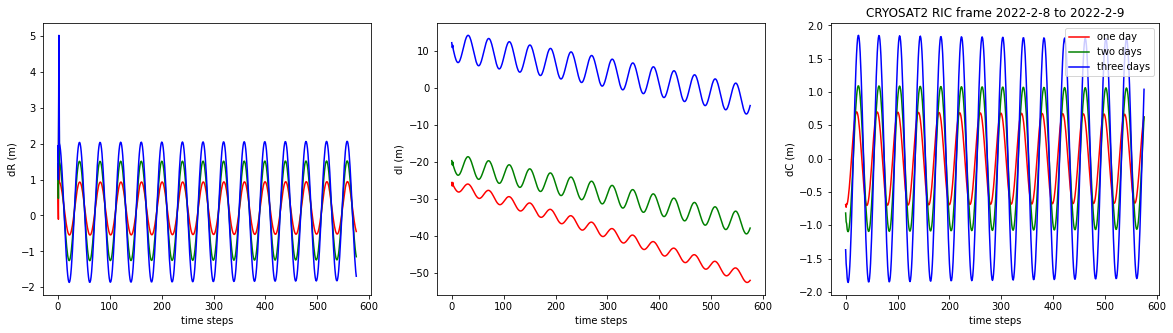

In [182]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
plt.title("CRYOSAT2 RIC frame 2022-2-8 to 2022-2-9")
ax1.plot(ts_12_to_13,cryo22_dR1,'r',label="one day")
ax1.plot(ts_12_to_13,cryo22_dR2,'g',label="two days")
ax1.plot(ts_12_to_13,cryo22_dR3,'b',label="three days")
ax2.plot(ts_12_to_13,cryo22_dI1,'r',label="one day")
ax2.plot(ts_12_to_13,cryo22_dI2,'g',label="two days")
ax2.plot(ts_12_to_13,cryo22_dI3,'b',label="three days")
ax3.plot(ts_12_to_13,cryo22_dC1,'r',label="one day")
ax3.plot(ts_12_to_13,cryo22_dC2,'g',label="two days")
ax3.plot(ts_12_to_13,cryo22_dC3,'b',label="three days")

ax1.set_xlabel("time steps")
ax2.set_xlabel("time steps")
ax3.set_xlabel("time steps")
ax1.set_ylabel("dR (m)")
ax2.set_ylabel("dI (m)")
ax3.set_ylabel("dC (m)")
plt.legend()
plt.show()

In [226]:
print("In-track one day error:", abs(round(statistics.mean(cryo22_dI1),3))+round(statistics.pstdev(cryo22_dI1),3), "m")
print("In-track two days error:", abs(round(statistics.mean(cryo22_dI2),3))+round(statistics.pstdev(cryo22_dI2),3), "m")
print("In-track three days error:", abs(round(statistics.mean(cryo22_dI3),3))+round(statistics.pstdev(cryo22_dI3),3), "m")

In-track one day error: 46.117999999999995 m
In-track two days error: 33.841 m
In-track three days error: 9.087 m
